In [1]:
import torch as th
from active_critic.learner.active_critic_learner import ActiveCriticLearner, ACLScores
from active_critic.learner.active_critic_args import ActiveCriticLearnerArgs
from active_critic.policy.active_critic_policy import ActiveCriticPolicy
from active_critic.utils.gym_utils import make_dummy_vec_env, parse_sampled_transitions, sample_expert_transitions, DummyExtractor, new_epoch_reach, sample_new_episode
from active_critic.utils.pytorch_utils import make_part_obs_data, count_parameters
from active_critic.utils.dataset import DatasetAC
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from active_critic.utils.dataset import DatasetAC
from active_critic.model_src.whole_sequence_model import (
    WholeSequenceModelSetup, WholeSequenceModel)
from active_critic.model_src.transformer import (
    ModelSetup, generate_square_subsequent_mask)
from active_critic.policy.active_critic_policy import ActiveCriticPolicySetup, ActiveCriticPolicy


from gym import Env
th.manual_seed(0)


def make_wsm_setup(seq_len, d_output, device='cuda'):
    wsm = WholeSequenceModelSetup()
    wsm.model_setup = ModelSetup()
    seq_len = seq_len
    d_output = d_output
    wsm.model_setup.d_output = d_output
    wsm.model_setup.nhead = 1
    wsm.model_setup.d_hid = 512
    wsm.model_setup.d_model = 512
    wsm.model_setup.nlayers = 4
    wsm.model_setup.seq_len = seq_len
    wsm.model_setup.dropout = 0
    wsm.lr = 1e-4
    wsm.model_setup.device = device
    wsm.optimizer_class = th.optim.Adam
    wsm.optimizer_kwargs = {}
    return wsm


def make_acps(seq_len, extractor, new_epoch, batch_size=32):
    acps = ActiveCriticPolicySetup()
    acps.device = 'cuda'
    acps.epoch_len = seq_len
    acps.extractor = extractor
    acps.new_epoch = new_epoch
    acps.opt_steps = 100
    acps.optimisation_threshold = 0.95
    acps.inference_opt_lr = 5e-2
    acps.optimize = True
    acps.batch_size = 32
    return acps


def setup_ac_reach(seq_len=5):
    seq_len = seq_len
    env, gt_policy = make_dummy_vec_env('reach', seq_len=seq_len)
    d_output = env.action_space.shape[0]
    wsm_actor_setup = make_wsm_setup(
        seq_len=seq_len, d_output=d_output)
    wsm_critic_setup = make_wsm_setup(
        seq_len=seq_len, d_output=1)
    acps = make_acps(
        seq_len=seq_len, extractor=DummyExtractor(), new_epoch=new_epoch_reach)
    actor = WholeSequenceModel(wsm_actor_setup)
    critic = WholeSequenceModel(wsm_critic_setup)
    ac = ActiveCriticPolicy(observation_space=env.observation_space, action_space=env.action_space,
                            actor=actor, critic=critic, acps=acps)
    return ac, acps, env


def make_acl():
    device = 'cuda'
    acla = ActiveCriticLearnerArgs()
    acla.data_path = '/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/'
    acla.device = device
    acla.extractor = DummyExtractor()
    acla.imitation_phase = False
    acla.logname = 'reach_org_test'
    acla.tboard = True
    acla.batch_size = 32
    acla.val_every = 10
    acla.add_data_every = 1
    acla.validation_episodes = 5
    acla.actor_threshold = 1e-2
    acla.critic_threshold = 1e-2
    seq_len = 100
    epsiodes = 30
    ac, acps, env = setup_ac_reach(seq_len=seq_len)
    acl = ActiveCriticLearner(ac_policy=ac, env=env, network_args_obj=acla)
    env, expert = make_dummy_vec_env(name='reach', seq_len=seq_len)
    return acl, env, expert, seq_len, epsiodes, device


/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-10-12 16:18:32.018152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 16:18:32.110695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/hendrik/Documents/master_project/CoppeliaSim_Player_V4_1_0_Ubuntu20_04:/home/hendrik/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-10-12 16:

2022-10-12 16:18:34.168502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 16:18:34.168710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/hendrik/Documents/master_project/CoppeliaSim_Player_V4_1_0_Ubuntu20_04:/home/hendrik/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-10-12 16:18:34.168756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/hendrik/Documents/master_project/CoppeliaSim_Player_V4_1_0_Ubuntu20_04:/home/hendrik/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-10-12 16:18:34.168798: 

Sampling expert transitions. 30


/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/metaworld/policies/policy.py:41: UserWarning: Constant(s) may be too high. Environments clip response to [-1, 1]
  warnings.warn('Constant(s) may be too high. Environments clip response to [-1, 1]')


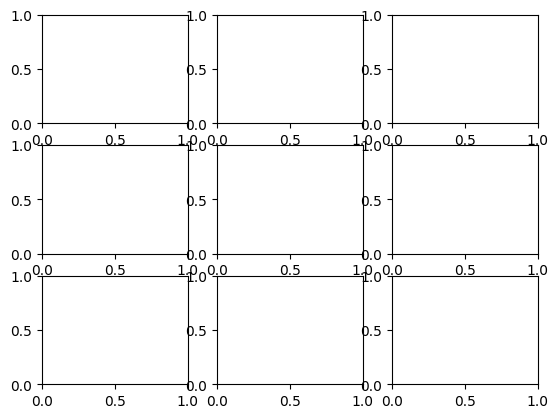

In [2]:
acl, env, expert, seq_len, epsiodes, device = make_acl()
env, expert = make_dummy_vec_env(name='reach', seq_len=seq_len)
transitions = sample_expert_transitions(
    policy=expert.predict, env=env, episodes=epsiodes)
exp_actions, exp_observations, exp_rewards = parse_sampled_transitions(
    transitions=transitions, new_epoch=new_epoch_reach, extractor=DummyExtractor(), device=device)
part_acts, part_obsv, part_rews = make_part_obs_data(
    actions=exp_actions, observations=exp_observations, rewards=exp_rewards)
imitation_data = DatasetAC(device='cuda')
imitation_data.onyl_positiv = False
imitation_data.add_data(obsv=part_obsv, actions=part_acts, reward=part_rews)
# acl.setDatasets(train_data=imitation_data)


In [3]:
acl.train(epochs=10000)

Sampling expert transitions. 1
Sampling expert transitions. 5
/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/best_validation
Sampling expert transitions. 1
Sampling expert transitions. 5


KeyboardInterrupt: 

In [ ]:
acl.policy.score_history_after
